EyeQ: Computer Vision based ML Detection on Diabetic Retinopathy (DR) Detect Early, Protect Vision!

In [1]:
#Importing Libraries

import pandas as pd                # For handling and analyzing data
from glob import glob              # For retrieving file paths matching a specified pattern
import os                          # For interacting with the operating system, such as directory and file handling
import cv2                         # OpenCV library for image processing
import numpy as np                 # For numerical operations, such as working with arrays
from collections import Counter    # To count occurrences of elements in a collection (useful for counting labels in data)
import matplotlib.pyplot as plt    # For plotting and visualizing data
import seaborn as sns              # For enhanced data visualization; provides aesthetic and easily customizable charts
import csv                         # For reading from and writing to CSV (Comma-Separated Values) files

# Enable inline plotting in Jupyter Notebook
%matplotlib inline

In [2]:
#Reading the trainLabels CSV file

df=pd.read_csv(r"/kaggle/input/eye-q/trainLabels.csv/trainLabels.csv")
df.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [3]:
#Gathering Info

df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 29458 entries, 0 to 29457

Data columns (total 2 columns):

 #   Column  Non-Null Count  Dtype 

---  ------  --------------  ----- 

 0   image   29458 non-null  object

 1   level   29458 non-null  int64 

dtypes: int64(1), object(1)

memory usage: 460.4+ KB


In [4]:
#Counting the frequency of labels

count = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}            # Keys (0, 1, 2, 3, 4) represent different levels, and values (initially set to 0) will store the count for each level

for c in df['level']:                             # Iterate over each 'level' entry in the 'df' DataFrame
    count[c] += 1                                 # For each level value in 'df['level']', increment the corresponding count in the dictionary

for c, count_value in count.items():              # 'c' represents the level, and 'count_value' is the count of images or entries for that level
    print(f"Level {c}: {count_value}")            # Print the count for each level

Level 0: 21573

Level 1: 2049

Level 2: 4488

Level 3: 758

Level 4: 590


In [5]:

def load_images_with_paths(csv_file, image_folder):

    """
    Load image names from a CSV file and generate full paths for each image.

    Parameters:
    - csv_file (str): Path to the CSV file containing image names.
    - image_folder (str): Directory where the images are stored.

    Returns:
    - df (DataFrame): A DataFrame containing image names and corresponding full image paths.
    """
    
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)

    # Add a new column 'image_path' to the DataFrame, containing the full path to each image.
    # This uses the 'image' column and appends the '.jpeg' extension, then combines with the image_folder path.
    df['image_path'] = df['image'].apply(lambda img_name: os.path.join(image_folder, f"{img_name}.jpeg"))

    return df

# Define paths to the CSV file and image folder
csv_file = '/kaggle/input/eye-q/trainLabels.csv/trainLabels.csv'  
image_folder = '/kaggle/input/eye-q/train/train'

# Load the DataFrame with image names and their full paths
df = load_images_with_paths(csv_file, image_folder)

# Display the first 20 rows of the DataFrame to verify the contents
print(df.head(20))



       image  level                                     image_path

0    10_left      0   /kaggle/input/eye-q/train/train/10_left.jpeg

1   10_right      0  /kaggle/input/eye-q/train/train/10_right.jpeg

2    13_left      0   /kaggle/input/eye-q/train/train/13_left.jpeg

3   13_right      0  /kaggle/input/eye-q/train/train/13_right.jpeg

4    15_left      1   /kaggle/input/eye-q/train/train/15_left.jpeg

5   15_right      2  /kaggle/input/eye-q/train/train/15_right.jpeg

6    16_left      4   /kaggle/input/eye-q/train/train/16_left.jpeg

7   16_right      4  /kaggle/input/eye-q/train/train/16_right.jpeg

8    17_left      0   /kaggle/input/eye-q/train/train/17_left.jpeg

9   17_right      1  /kaggle/input/eye-q/train/train/17_right.jpeg

10   19_left      0   /kaggle/input/eye-q/train/train/19_left.jpeg

11  19_right      0  /kaggle/input/eye-q/train/train/19_right.jpeg

12   20_left      0   /kaggle/input/eye-q/train/train/20_left.jpeg

13  20_right      0  /kaggle/input/eye-q/train/t

In [7]:
# Import necessary library for mathematical operations 
import math

# Function to filter the DataFrame by a specific level and retrieve image paths
def get_filelist(level=0):
    return df[df['level'] == level]['image_path'].values

# Function to plot images in a grid format
def subplots(filelist):
    plt.figure(figsize=(16, 12))                     # Set the size of the overall figure (width, height in inches)
    ncol = 3                                         # Define the number of columns for the grid layout
    nrow = math.ceil(len(filelist) // ncol)          # Calculate the required number of rows based on the number of images
    
    for i in range(0, len(filelist)):                # Loop over each image path in the filelist
        plt.subplot(nrow, ncol, i + 1)               # Create a subplot for each image with an index based on grid position
        img = cv2.imread(filelist[i])                # Read the image from file
        plt.imshow(img)                              # Display the image on the subplot

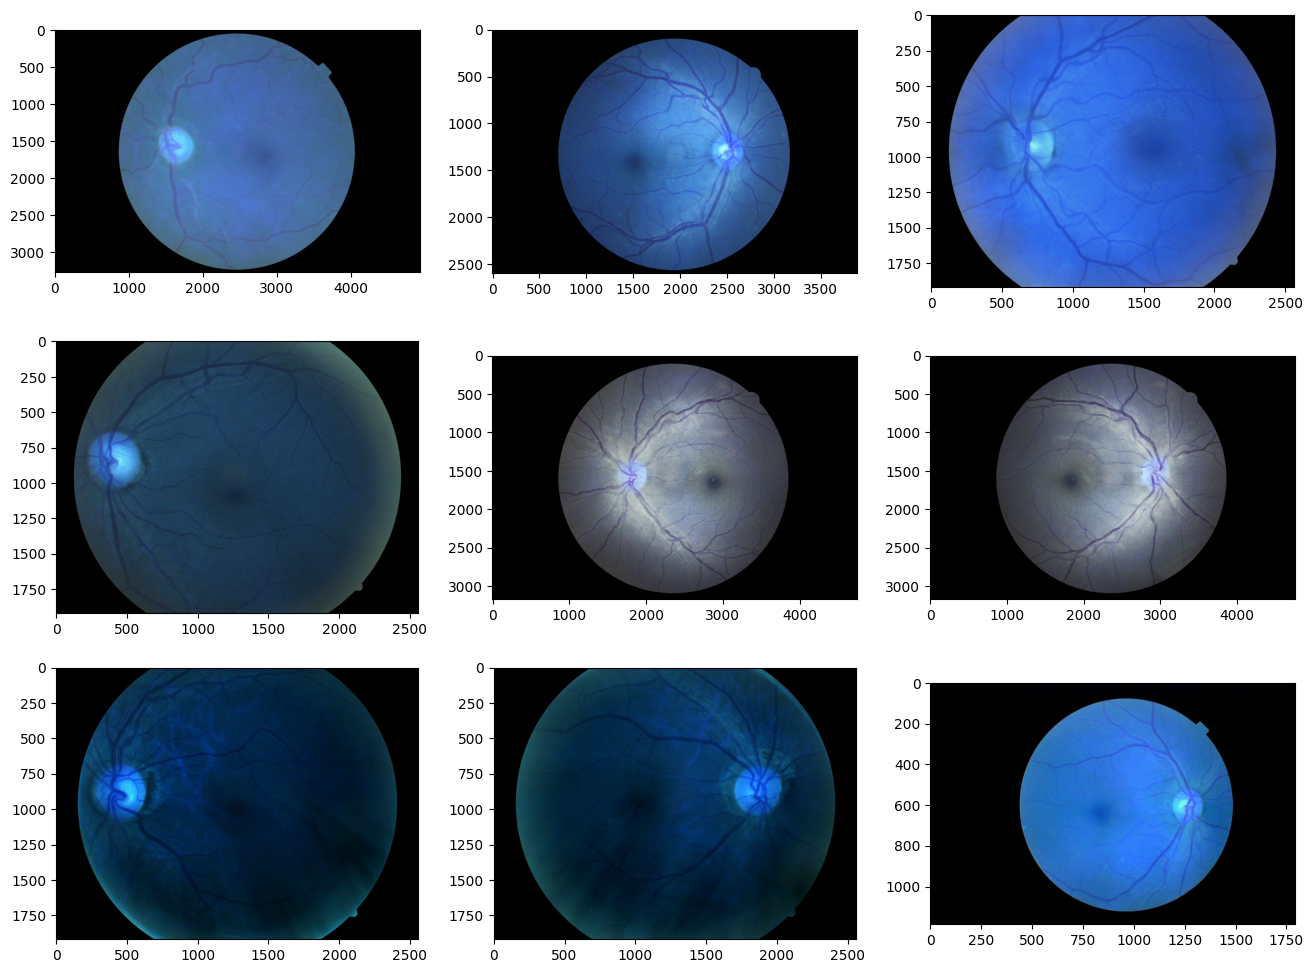

In [8]:
filelist = get_filelist(level=1)                     # Retrieve a list of image paths for images at level 1
subplots(filelist[:9])                               # Display the first 9 images in the list in a grid layout

In [6]:
from sklearn.model_selection import train_test_split                         # For splitting data into training and testing sets
from tensorflow.keras.utils import to_categorical                            # For one-hot encoding labels
from tensorflow.keras.preprocessing.image import ImageDataGenerator          # For augmenting images

# Function to adjust saturation, hue, and brightness
def adjust_saturation_hue_brightness(img, saturation=1.0, hue=0, brightness=0):
    """
    Adjust the saturation, hue, and brightness of the image.

    Parameters:
    - img (ndarray): The input image to be adjusted.
    - saturation (float): The factor by which to adjust saturation.
    - hue (int): The degree by which to shift hue.
    - brightness (int): The brightness adjustment factor.
    
    Returns:
    - img (ndarray): The adjusted image.
    """
    if img is None or img.size == 0:
        print("Warning: Attempting to adjust an empty image.")
        return img  # Return early if the image is invalid

    # Convert to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Adjust saturation
    hsv[:, :, 1] = np.clip(hsv[:, :, 1] * saturation, 0, 255)
    
    # Adjust hue (rotate values between 0 and 179 degrees)
    hsv[:, :, 0] = np.clip(hsv[:, :, 0] + hue, 0, 179)
    
    # Convert back to BGR format
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    # Adjust brightness
    img = cv2.convertScaleAbs(img, alpha=1, beta=brightness)
    
    return img

# Function to estimate the radius of the image
def estimate_radius(img):
    """
    Estimate the radius of the content in the image using its center row and column.

    Parameters:
    - img (ndarray): The input image.
    
    Returns:
    - (float, float): Estimated radii (ry, rx) along the y and x axes.
    """
    if img is None or img.size == 0:
        return 0, 0

    # Calculate radius along the x and y dimensions
    mx = img[img.shape[0] // 2, :, :].sum(1)
    rx = (mx > mx.mean() / 10).sum() / 2

    my = img[:, img.shape[1] // 2, :].sum(1)
    ry = (my > my.mean() / 10).sum() / 2

    return (ry, rx)

# Function to crop the image
def crop_img(img, h, w):
    """
    Crop the image to the specified height and width, centered.

    Parameters:
    - img (ndarray): The input image.
    - h (int): Desired height of the cropped image.
    - w (int): Desired width of the cropped image.
    
    Returns:
    - crop_img (ndarray): The cropped image.
    """
    if img is None or img.size == 0:
        return img                    # Return early if the image is invalid

    # Calculate margins for cropping
    h_margin = (img.shape[0] - h) // 2 if img.shape[0] > h else 0
    w_margin = (img.shape[1] - w) // 2 if img.shape[1] > w else 0

    # Crop and handle empty images
    crop_img = img[h_margin:h + h_margin, w_margin:w + w_margin, :]
    if crop_img.size == 0:
        print("Warning: Cropped image is empty.")
        
    return crop_img

# Initialize lists to store images and levels
images = []
levels = []

# Initialize counters to balance classes
x1 = x2 = x3 = x4 = x5 = 0  

# ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Iterate through each row in the DataFrame to process images
for index, row in df.iterrows():
    image_path = row['image_path']
    label = row['level']

    # Skip images if maximum for class is reached to balance classes
    if label == 0 and x1 > 3000:
        continue
    elif label == 1 and x2 > 2039:
        continue
    elif label == 2 and x3 > 3000:
        continue
    elif label == 3 and x4 > 2200:
        continue
    elif label == 4 and x5 > 2000:
        continue

    # Load the image
    img = cv2.imread(image_path)
    
    if img is None or img.size == 0:
        print(f"Warning: Image at {image_path} could not be loaded or is invalid.")
        continue

    # Estimate radius and resize image
    ry, rx = estimate_radius(img)
    if rx == 0 or ry == 0:
        print(f"Warning: Radius estimation failed for image at {image_path}")
        continue

    resize_scale = 256 / max(rx, ry)
    w = min(int(rx * resize_scale * 2), 256 * 2)
    h = min(int(ry * resize_scale * 2), 256 * 2)
    img_resize = cv2.resize(img.copy(), (h, w), fx=resize_scale, fy=resize_scale)

    if img_resize.size == 0:
        print(f"Warning: Resized image is empty at {image_path}")
        continue

    # Crop image
    img_crop = crop_img(img_resize.copy(), h, w)

    if img_crop.size == 0:
        print(f"Warning: Cropped image is empty at {image_path}")
        continue

    # Adjust saturation, hue, and brightness
    img_adjusted = adjust_saturation_hue_brightness(img_crop, saturation=1.2, hue=10, brightness=30)

    if img_adjusted is None or img_adjusted.size == 0:
        print(f"Warning: Adjusted image is invalid for {image_path}")
        continue

    # Resize the final image to a fixed size (e.g., 224x224)
    img_final = cv2.resize(img_adjusted, (224, 224))

    # Append processed image and label to lists
    images.append(img_final)
    levels.append(label)

    # Augmentation for x4 and x5 classes
    if label == 3 and x4 <= 2200:
        x4 += 3
        img_augmented = np.expand_dims(img_final, axis=0)
        for i in range(3):  # Create 10 augmented images
            aug_iter = datagen.flow(img_augmented, batch_size=1)
            augmented_image = next(aug_iter)[0].astype('uint8')
            images.append(augmented_image)
            levels.append(3)
    elif label == 4 and x5 <= 2000:
        x5 += 4
        img_augmented = np.expand_dims(img_final, axis=0)
        for i in range(4):  # Create 10 augmented images
            aug_iter = datagen.flow(img_augmented, batch_size=1)
            augmented_image = next(aug_iter)[0].astype('uint8')
            images.append(augmented_image)
            levels.append(4)

# Convert lists to numpy arrays for model training
X = np.array(images)
Y = np.array(levels)

# One-hot encode the labels for the model
Y = to_categorical(Y, 5)

# Split the data into training and testing sets (70% training, 30% testing)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Print shapes of training and testing sets for verification
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)



x_train shape: (23485, 224, 224, 3)

y_train shape: (23485, 5)

x_test shape: (10065, 224, 224, 3)

y_test shape: (10065, 5)


In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Multiply
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Define Attention Layer
def attention_layer(inputs):
    """
    Applies self-attention mechanism to the input.
    
    Parameters:
    - inputs (tensor): Input tensor to apply attention on.
    
    Returns:
    - attention_mul (tensor): The output tensor after applying self-attention.
    """
    # Create attention scores using a Dense layer with softmax activation
    attention_probs = Dense(inputs.shape[-1], activation='softmax')(inputs)
    
    # Multiply inputs by attention scores to get the weighted output
    attention_mul = Multiply()([inputs, attention_probs])
    
    return attention_mul

# Load InceptionV3 pre-trained on ImageNet without the top (fully connected) layers
base_model = InceptionV3(weights='imagenet', include_top=False)

# Add new layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Apply self-attention mechanism to the pooled output
attention_output = attention_layer(x)

# Add dense layers after the attention mechanism
x = Dense(1024, activation='relu')(attention_output)    # Fully connected layer with ReLU activation
predictions = Dense(5, activation='softmax')(x)         # Output layer for 5 classes with softmax activation

# Define the new model with inputs from the base model and outputs from the predictions layer
model = Model(inputs=base_model.input, outputs=predictions)

# Make all layers trainable (optional)
for layer in base_model.layers:
    layer.trainable = False                             # Freeze the base model layers to avoid updating during training

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Set up the model checkpoint to save the best weights based on validation accuracy
checkpoint = ModelCheckpoint(
    filepath='v3_attention_best_weights.keras',         # Filepath to save the model
    monitor='val_accuracy',                             # Monitor the validation accuracy
    save_best_only=True,                                # Only save the model if validation accuracy improves
    mode='max',                                         # Save the model with the highest validation accuracy
    verbose=1                                           # Print messages when saving checkpoints
)

# Fit the model and include the checkpoint callback
history = model.fit(
    x_train,
    y_train,
    epochs=10,
    validation_data=(x_test, y_test),  # Add validation data
    callbacks=[checkpoint]  # Add the checkpoint callback
)

# Save the final model (not necessarily the best one)
model.save('v3_attention_final.keras')


Num GPUs Available:  1


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

Epoch 1/10



I0000 00:00:1730024008.577471     478 service.cc:145] XLA service 0x79a03c003e90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:

I0000 00:00:1730024008.581520     478 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  3/734 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.3021 - loss: 1.6512   

I0000 00:00:1730024017.161703     478 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


733/734 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6402 - loss: 1.1378

Epoch 2: val_accuracy did not improve from 0.64988

734/734 ━━━━━━━━━━━━━━━━━━━━ 42s 57ms/step - accuracy: 0.6402 - loss: 1.1378 - val_accuracy: 0.6499 - val_loss: 1.1139

Epoch 3/10

734/734 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6444 - loss: 1.1283

Epoch 3: val_accuracy did not improve from 0.64988

734/734 ━━━━━━━━━━━━━━━━━━━━ 41s 57ms/step - accuracy: 0.6444 - loss: 1.1283 - val_accuracy: 0.6499 - val_loss: 1.1135

Epoch 4/10

733/734 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6422 - loss: 1.1327

Epoch 4: val_accuracy did not improve from 0.64988

734/734 ━━━━━━━━━━━━━━━━━━━━ 42s 57ms/step - accuracy: 0.6422 - loss: 1.1327 - val_accuracy: 0.6499 - val_loss: 1.1145

Epoch 5/10

733/734 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6383 - loss: 1.1405

Epoch 5: val_accuracy did not improve from 0.64988

734/734 ━━━━━━━━━━━━━━━━━━━━ 41s 56ms/step - accuracy: 0.6383 - loss: 1.1405 - val_accur

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Multiply
from tensorflow.keras.callbacks import ModelCheckpoint

# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Define Attention Layer
def attention_layer(inputs):
    """Applies self-attention mechanism to the input."""
    attention_probs = Dense(inputs.shape[-1], activation='softmax')(inputs)
    attention_mul = Multiply()([inputs, attention_probs])
    return attention_mul

# Load VGG16 pre-trained on ImageNet without the top (fully connected) layers
base_model = InceptionV3(weights='imagenet', include_top=False)

# Add new layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Apply self-attention mechanism
attention_output = attention_layer(x)

# Add dense layers after the attention mechanism
x = Dense(1024, activation='relu')(attention_output)
predictions = Dense(5, activation='softmax')(x)  # Assuming 5 classes for the classification

# Define the new model
model = Model(inputs=base_model.input, outputs=predictions)

# Load the weights from the best checkpoint
model.load_weights('v3_attention_best_weights.keras')

for layer in base_model.layers[-10:]:  # Unfreeze the last 50 layers of the base model
    layer.trainable = True

# Compile the model (if necessary)
model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), metrics=['accuracy'])

# Define the checkpoint to save new best weights during continued training
checkpoint = ModelCheckpoint(
    filepath='v3_attention_continued_best_weights.keras',  # Filepath to save the model
    monitor='val_accuracy',  # Monitor the validation accuracy
    save_best_only=True,  # Only save the model if validation accuracy improves
    mode='max',  # Save the model with the highest validation accuracy
    verbose=1  # Print messages when saving checkpoints
)

# Continue training for 50 more epochs
history = model.fit(
    x_train,
    y_train,
    epochs=30,  # Additional epochs
    validation_data=(x_test, y_test),  # Add validation data
    callbacks=[checkpoint]  # Add the checkpoint callback
)

# Optionally save the final model after continued training
model.save('v3_attention_final_continued.keras')


Num GPUs Available:  1

Epoch 1/30

734/734 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.6373 - loss: 1.1688

Epoch 1: val_accuracy improved from -inf to 0.64988, saving model to v3_attention_continued_best_weights.keras

734/734 ━━━━━━━━━━━━━━━━━━━━ 226s 213ms/step - accuracy: 0.6373 - loss: 1.1688 - val_accuracy: 0.6499 - val_loss: 1.0897

Epoch 2/30

734/734 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6391 - loss: 1.0649

Epoch 2: val_accuracy improved from 0.64988 to 0.66905, saving model to v3_attention_continued_best_weights.keras

734/734 ━━━━━━━━━━━━━━━━━━━━ 115s 157ms/step - accuracy: 0.6391 - loss: 1.0649 - val_accuracy: 0.6691 - val_loss: 0.9259

Epoch 3/30

734/734 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6684 - loss: 0.9152

Epoch 3: val_accuracy improved from 0.66905 to 0.72648, saving model to v3_attention_continued_best_weights.keras

734/734 ━━━━━━━━━━━━━━━━━━━━ 115s 157ms/step - accuracy: 0.6685 - loss: 0.9152 - val_accuracy: 0.7265 - val_loss: 0.8482

In [2]:
import os
import cv2
import pandas as pd
import numpy as np

def load_samples(image_folder):
    """
    Load image paths from the specified folder and return a DataFrame with image names and paths.

    Parameters:
    - image_folder (str): The path to the folder containing the images.

    Returns:
    - pd.DataFrame: A DataFrame containing two columns:
        - 'image': The name of the image file.
        - 'image_path': The full path to the image file.
    """
    # List all image files in the directory
    image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpeg')]

    # Create a DataFrame with the image names and their corresponding full paths
    df = pd.DataFrame(image_files, columns=['image'])
    df['image_path'] = df['image'].apply(lambda img_name: os.path.join(image_folder, img_name))

    return df

# Example usage of the load_samples function
sample_folder = '/kaggle/input/eye-q/test/test'  # Folder where the images are stored
df = load_samples(sample_folder)                   # Load the samples into a DataFrame
print(df.head())                                   # Display the first few rows of the DataFrame to check the results

              image                                      image_path
0  38111_right.jpeg  /kaggle/input/eye-q/test/test/38111_right.jpeg
1  40447_right.jpeg  /kaggle/input/eye-q/test/test/40447_right.jpeg
2   39457_left.jpeg   /kaggle/input/eye-q/test/test/39457_left.jpeg
3  43894_right.jpeg  /kaggle/input/eye-q/test/test/43894_right.jpeg
4   38477_left.jpeg   /kaggle/input/eye-q/test/test/38477_left.jpeg


In [ ]:
def preprocess_image(image_path, img_size=(224, 224)):
   """
    Preprocess the image for prediction by resizing, normalizing, and adjusting image properties.

    Parameters:
    - image_path (str): The path to the image file to be preprocessed.
    - img_size (tuple): The desired output size of the image. Default is (224, 224).

    Returns:
    - np.ndarray: The preprocessed image ready for prediction, with shape (1, height, width, channels).
    """
    # Load the image
    img = cv2.imread(image_path)

    # Estimate the radius of the image for resizing purposes
    ry, rx = estimate_radius(img)
    if rx == 0 or ry == 0:
        print(f"Warning: Radius estimation failed for image at {image_path}")
        continue

    # Calculate the scaling factor for resizing
    resize_scale = 256 / max(rx, ry)
    w = min(int(rx * resize_scale * 2), 256 * 2)
    h = min(int(ry * resize_scale * 2), 256 * 2)
    img_resize = cv2.resize(img.copy(), (h, w), fx=resize_scale, fy=resize_scale)

    if img_resize.size == 0:
        print(f"Warning: Resized image is empty at {image_path}")
        continue

    # Crop image
    img_crop = crop_img(img_resize.copy(), h, w)

    if img_crop.size == 0:
        print(f"Warning: Cropped image is empty at {image_path}")
        continue

    # Adjust saturation, hue, and brightness
    img_adjusted = adjust_saturation_hue_brightness(img_crop, saturation=1.2, hue=10, brightness=30)

    if img_adjusted is None or img_adjusted.size == 0:
        print(f"Warning: Adjusted image is invalid for {image_path}")
        continue

    # Resize the final image to a fixed size (e.g., 224x224)
    img_final = cv2.resize(img_adjusted, (224, 224))

    # Add a batch dimension
    img_normalized = np.expand_dims(img_final, axis=0)

    # Return the preprocessed image
    return img_normalized


In [ ]:
from tensorflow.keras.models import load_model

x=0
# Load your pre-trained model
model = load_model('/kaggle/input/v3.keras/keras/default/1/v3_attention_continued_best_weights (1).keras')  # Update with the correct path to your model

# Initialize a list to store the results
predictions = []

# Loop through the DataFrame and make predictions
for index, row in df.iterrows():
    image_path = row['image_path']
    x=x+1
    if x==10:
        break
        # Get the predicted class (e.g., argmax if it's a classification problem)
    predicted_class = np.argmax(pred, axis=1)[0]

        # Append the image name and predicted class to the results
    predictions.append({
            'image': row['image'],
            'level': predicted_class
        })

# Create a DataFrame for the submission
submission_df = pd.DataFrame(predictions)

In [ ]:
# Save the predictions to a CSV file for submission
submission_df.to_csv('submission.csv', index=False)

# Save the submission file
print(submission_df.head())

In [4]:
from sklearn.model_selection import train_test_split                         # For splitting data into training and testing sets
from tensorflow.keras.utils import to_categorical                            # For one-hot encoding labels
from tensorflow.keras.preprocessing.image import ImageDataGenerator          # For augmenting images

# Function to adjust saturation, hue, and brightness
def adjust_saturation_hue_brightness(img, saturation=1.0, hue=0, brightness=0):
    """
    Adjust the saturation, hue, and brightness of the image.

    Parameters:
    - img (ndarray): The input image to be adjusted.
    - saturation (float): The factor by which to adjust saturation.
    - hue (int): The degree by which to shift hue.
    - brightness (int): The brightness adjustment factor.
    
    Returns:
    - img (ndarray): The adjusted image.
    """
    if img is None or img.size == 0:
        print("Warning: Attempting to adjust an empty image.")
        return img  # Return early if the image is invalid

    # Convert to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Adjust saturation
    hsv[:, :, 1] = np.clip(hsv[:, :, 1] * saturation, 0, 255)
    
    # Adjust hue (rotate values between 0 and 179 degrees)
    hsv[:, :, 0] = np.clip(hsv[:, :, 0] + hue, 0, 179)
    
    # Convert back to BGR format
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    # Adjust brightness
    img = cv2.convertScaleAbs(img, alpha=1, beta=brightness)
    
    return img

# Function to estimate the radius of the image
def estimate_radius(img):
    """
    Estimate the radius of the content in the image using its center row and column.

    Parameters:
    - img (ndarray): The input image.
    
    Returns:
    - (float, float): Estimated radii (ry, rx) along the y and x axes.
    """
    if img is None or img.size == 0:
        return 0, 0

    # Calculate radius along the x and y dimensions
    mx = img[img.shape[0] // 2, :, :].sum(1)
    rx = (mx > mx.mean() / 10).sum() / 2

    my = img[:, img.shape[1] // 2, :].sum(1)
    ry = (my > my.mean() / 10).sum() / 2

    return (ry, rx)

# Function to crop the image
def crop_img(img, h, w):
    """
    Crop the image to the specified height and width, centered.

    Parameters:
    - img (ndarray): The input image.
    - h (int): Desired height of the cropped image.
    - w (int): Desired width of the cropped image.
    
    Returns:
    - crop_img (ndarray): The cropped image.
    """
    if img is None or img.size == 0:
        return img                    # Return early if the image is invalid

    # Calculate margins for cropping
    h_margin = (img.shape[0] - h) // 2 if img.shape[0] > h else 0
    w_margin = (img.shape[1] - w) // 2 if img.shape[1] > w else 0

    # Crop and handle empty images
    crop_img = img[h_margin:h + h_margin, w_margin:w + w_margin, :]
    if crop_img.size == 0:
        print("Warning: Cropped image is empty.")
        
    return crop_img

# Initialize lists to store images and levels
images = []
levels = []

# Initialize counters to balance classes
x1 = x2 = x3 = x4 = x5 = 0  

# ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Iterate through each row in the DataFrame to process images
for index, row in df.iterrows():
    image_path = row['image_path']
    # Skip images if maximum for class is reached to balance classes
    # Load the image
    img = cv2.imread(image_path)
    
    if img is None or img.size == 0:
        print(f"Warning: Image at {image_path} could not be loaded or is invalid.")
        continue

    # Estimate radius and resize image
    ry, rx = estimate_radius(img)
    if rx == 0 or ry == 0:
        print(f"Warning: Radius estimation failed for image at {image_path}")
        continue

    resize_scale = 256 / max(rx, ry)
    w = min(int(rx * resize_scale * 2), 256 * 2)
    h = min(int(ry * resize_scale * 2), 256 * 2)
    img_resize = cv2.resize(img.copy(), (h, w), fx=resize_scale, fy=resize_scale)

    if img_resize.size == 0:
        print(f"Warning: Resized image is empty at {image_path}")
        continue

    # Crop image
    img_crop = crop_img(img_resize.copy(), h, w)

    if img_crop.size == 0:
        print(f"Warning: Cropped image is empty at {image_path}")
        continue

    # Adjust saturation, hue, and brightness
    img_adjusted = adjust_saturation_hue_brightness(img_crop, saturation=1.2, hue=10, brightness=30)

    if img_adjusted is None or img_adjusted.size == 0:
        print(f"Warning: Adjusted image is invalid for {image_path}")
        continue

    # Resize the final image to a fixed size (e.g., 224x224)
    img_final = cv2.resize(img_adjusted, (224, 224))

    # Append processed image and label to lists
    images.append(img_final)

    # Augmentation for x4 and x5 classes

# Convert lists to numpy arrays for model training
X = np.array(images)

# Print shapes of training and testing sets for verification
print("x_train shape:", X.shape)



x_train shape: (5668, 224, 224, 3)


In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Multiply
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical

In [7]:
from tensorflow.keras.models import load_model


In [9]:

# Load pre-trained model
import tensorflow as tf
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("Running on GPU")
else:
    print("No GPU available, running on CPU")
model = load_model('/kaggle/input/v3.keras/keras/default/1/v3_attention_continued_best_weights (1).keras')

batch_size = 32  # Adjust as needed based on your GPU memory
predictions = []
m=0
for start in range(0, len(X), batch_size):
    end = start + batch_size
    m+=1
    batch_preds = model.predict(X[start:end])
    batch_classes = np.argmax(batch_preds, axis=1)
    for j in range(len(batch_classes)):
        predictions.append({
            'image': df.iloc[start + j]['image'],
            'level': batch_classes[j]
        })


# Create a DataFrame for the predictions
submission_df = pd.DataFrame(predictions)
print(submission_df.head())
# Save the predictions to a CSV file for submission
submission_df.to_csv('submission.csv', index=False)

# Save the submission file
print(submission_df.head())

Running on GPU
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

In [10]:
# Convert the 'image' column to sort based on image number and left/right
submission_df['image_number'] = submission_df['image'].str.extract(r'(\d+)_')[0].astype(int)
submission_df['side'] = submission_df['image'].str.extract(r'_(left|right)')[0]

# Sort by image number first, then by 'left' before 'right'
submission_df = submission_df.sort_values(by=['image_number', 'side'], ascending=[True, True]).drop(columns=['image_number', 'side'])

# Reset the index after sorting
submission_df = submission_df.reset_index(drop=True)

print(submission_df.head())
submission_df.to_csv('submission.csv', index=False)

# Save the submission file
print(submission_df.head())

              image  level
0   37299_left.jpeg      0
1  37299_right.jpeg      0
2   37301_left.jpeg      0
3  37301_right.jpeg      2
4   37305_left.jpeg      0
              image  level
0   37299_left.jpeg      0
1  37299_right.jpeg      0
2   37301_left.jpeg      0
3  37301_right.jpeg      2
4   37305_left.jpeg      0


In [11]:
# Remove the '.jpeg' extension from the 'image' column
submission_df['image'] = submission_df['image'].str.replace('.jpeg', '', regex=False)

# Display the updated DataFrame
print(submission_df.head())
submission_df.to_csv('submission.csv', index=False)

# Save the submission file
print(submission_df.head())

         image  level
0   37299_left      0
1  37299_right      0
2   37301_left      0
3  37301_right      2
4   37305_left      0
         image  level
0   37299_left      0
1  37299_right      0
2   37301_left      0
3  37301_right      2
4   37305_left      0
